In [1]:
using LinearAlgebra, Distributions, Plots, Random, Zygote
include("simple_nn.jl")

sigmoid_activation (generic function with 1 method)

# XOR Problem

In [2]:
data = [
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
]

targets = [
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0]
];

In [3]:
xor_net = CreateNetwork([
    [2],
    [2, dense_layer, sigmoid_activation],
    [2, dense_layer, sigmoid_activation]
]);

In [4]:
lr = 0.01
epochs = 250
loss = 0.0

losses=[]

cross_entropy_loss(x_in, y_val) = -sum(y_val .* log.(FeedForward(xor_net, x_in)))

for epoch in 1:epochs
    for (i, input) in enumerate(data)
        x_in = convert(Vector{Float32}, input)
        
        pred = FeedForward(xor_net, x_in)
        y_val = targets[i]
        
        loss = cross_entropy_loss(x_in, y_val)
        
        g = gradient(Params([xor_net.weights, xor_net.biases])) do
            cross_entropy_loss(x_in, y_val)
        end

        dw = g[xor_net.weights]        
        xor_net.weights = xor_net.weights .- lr * dw
        
        db = g[xor_net.biases]        
        xor_net.biases = xor_net.biases .- lr * db

        if epoch % 50 == 0 && i == length(targets)
            println("Epoch $epoch\tPred: $(round(maximum(pred), digits=4))\tTarget: $(maximum(y_val))\tloss: $(round(loss, digits=4))")
        end
    end
    
    push!(losses, loss)
end

# testing predictions
preds = round.(maximum.([FeedForward(xor_net, convert(Vector{Float32}, x)) for x in data]))
passed = preds .== convert(Vector{Float32}, maximum.(targets))

println("\n$(sum(passed))/4 tests passed | Accuracy $(100 * sum(passed) / length(targets))%")

Epoch 50	Pred: 0.6934	Target: 1.0	loss: 0.468
Epoch 100	Pred: 0.7535	Target: 1.0	loss: 0.3156
Epoch 150	Pred: 0.7956	Target: 1.0	loss: 0.233
Epoch 200	Pred: 0.8329	Target: 1.0	loss: 0.1828
Epoch 250	Pred: 0.8611	Target: 1.0	loss: 0.1496

4/4 tests passed | Accuracy 100.0%


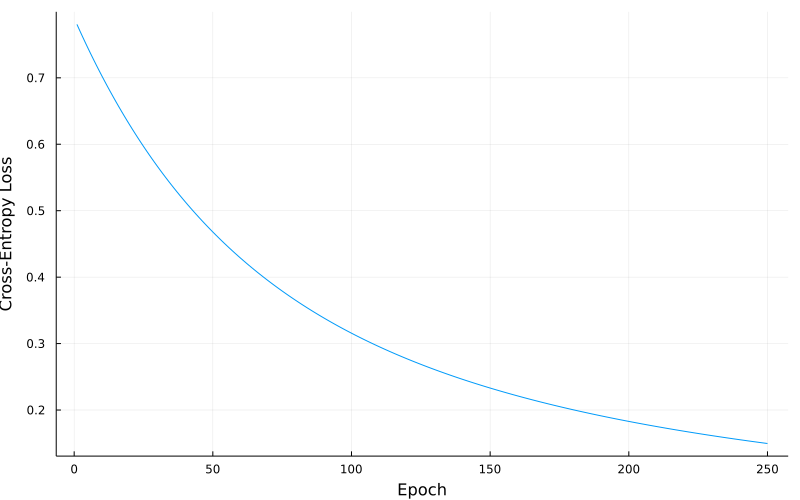

In [5]:
plot(losses, xlabel="Epoch", ylabel="Cross-Entropy Loss", label="", size=(800,500))